### Section 1.4.2 Linear Regulator
Taken from "Switch-Mode Power Supplies" by Christophe P. Basso

In [1]:
# Imports, type aliases

import tomllib
from pathlib import Path
from typing import Any

import py4spice as spi

In [2]:
# Constants

CONFIG_FILENAME = Path("/workspaces/py4spice/circuits/config.toml")
PROJECT_SECTION = "SEC_1_04_02"

class Ky:
    """Keys for dictionaries.  Defined here at top level so they can be
    referenced instead of using strings for keys.
    """

    # Keys for decoding config file
    GLOBAL = "GLOBAL"
    PROJECT = "PROJECT"
    NGSPICE_EXE_STR = "NGSPICE_EXE_STR"
    NETLISTS_DIR_STR = "NETLISTS_DIR_STR"
    RESULTS_DIR_STR = "RESULTS_DIR_STR"
    SIM_TRANSCRIPT_STR = "SIM_TRANSCRIPT_STR"
    PROJ_PATH_STR = "PROJ_PATH_STR"

    # Keys for the paths_dict
    NGSPICE_EXE = "ngspice_exe"
    PROJ_PATH = "proj_path"
    NETLISTS_PATH = "netlists_path"
    RESULTS_PATH = "results_path"
    SIM_TRANSCRIPT_FILENAME = "sim_transcript_filename"

    # Keys for the netlists_dict
    BLANKLINE = "blankline"
    TITLE = "title"
    END_LINE = "end_line"
    LOAD = "load"
    STIMULUS = "stimulus"
    SUPPLIES = "supplies"
    MODELS = "models"
    DUT = "dut"
    CONTROL = "control"
    TOP1 = "top1"

    # Keys for the vectors_dict
    VEC_ALL = "vec_all"
    VEC_ALL_EXPANDED = "vec_all_expanded"
    VEC_OUT = "vec_out"
    VEC_IN_OUT = "vec_in_out"
    VEC_INTEREST = "vec_interest"
    VEC_POWER_CALC = "vec_power_calc"
    VEC_ETA = "vec_eta"

In [3]:
# Initialization


def initialize() -> (
    tuple[dict[str, Path], dict[str, spi.Netlist], dict[str, spi.Vectors]]
):
    """All the setup we can do before running the different parts of the project"""
    # read config file and create config dictionary
    with open(CONFIG_FILENAME, "rb") as file:
        my_config: dict[str, Any] = tomllib.load(file)

    proj_path = Path(my_config[PROJECT_SECTION][Ky.PROJ_PATH_STR])

    # Create paths based on the config dictionary
    ngspice_exe: Path = Path(my_config[Ky.GLOBAL][Ky.NGSPICE_EXE_STR])
    netlists_path: Path = proj_path / my_config[Ky.GLOBAL][Ky.NETLISTS_DIR_STR]
    results_path: Path = proj_path / my_config[Ky.GLOBAL][Ky.RESULTS_DIR_STR]

    # create results directory if it does not exist
    results_path.mkdir(parents=True, exist_ok=True)

    # create simlulation transcript file. If it exists, make sure it is empty
    sim_tran_filename: Path = (
        results_path / my_config[Ky.GLOBAL][Ky.SIM_TRANSCRIPT_STR]
    )
    if sim_tran_filename.exists():  # delete and recreate. this makes sure it's empty
        sim_tran_filename.unlink()
    sim_tran_filename.touch()

    # create paths dictionary
    paths_dict = {
        Ky.NGSPICE_EXE: ngspice_exe,
        Ky.PROJ_PATH: proj_path,
        Ky.NETLISTS_PATH: netlists_path,
        Ky.RESULTS_PATH: results_path,
        Ky.SIM_TRANSCRIPT_FILENAME: sim_tran_filename,
    }

    # netlists_dict = define_netlists(paths_dict)
    netlists_path: Path = paths_dict[Ky.NETLISTS_PATH]  # make shorter alias
    netlists_dict: dict[str, spi.Netlist] = {}  # create empty netlist dictionary

    netlists_dict[Ky.BLANKLINE] = spi.Netlist("")  # blank line for spacing
    netlists_dict[Ky.TITLE] = spi.Netlist("* Title line")  # title line
    netlists_dict[Ky.END_LINE] = spi.Netlist(".end")  # end statement

    # create netlist objects from files and add to netlist dictionary
    netlists_dict[Ky.DUT] = spi.Netlist(netlists_path / "dut.cir")
    netlists_dict[Ky.LOAD] = spi.Netlist(netlists_path / "load.cir")
    netlists_dict[Ky.STIMULUS] = spi.Netlist(netlists_path / "stimulus.cir")
    netlists_dict[Ky.SUPPLIES] = spi.Netlist(netlists_path / "supplies.cir")
    netlists_dict[Ky.MODELS] = spi.Netlist(netlists_path / "models.cir")

    # Define a vector dictionary for simulation and post-simulation analysis
    vectors_dict = {
        Ky.VEC_ALL: spi.Vectors("all"),
        Ky.VEC_ALL_EXPANDED: spi.Vectors(
            "q1_base div e1#branch in out out_meas vee vee#branch vin#branch vmeas#branch ref vref#branch"
        ),
        Ky.VEC_IN_OUT: spi.Vectors("in out"),
        Ky.VEC_OUT: spi.Vectors("out"),
        Ky.VEC_INTEREST: spi.Vectors("in out div q1_base"),
        Ky.VEC_POWER_CALC: spi.Vectors("in vin#branch out vmeas#branch"),
        Ky.VEC_ETA: spi.Vectors("eta"),
    }
    return paths_dict, netlists_dict, vectors_dict


paths_dict, netlists_dict, vectors_dict = initialize()

#### Part 1: operating point and dc transfer
Say something!


--- Operating Point Results ---
base          5.765
div           2.499
e2#branch    −521.622µ
in            12.000
out           4.999
out_meas      0.000
ref           2.500
vee           0.000
vee#branch   −271.679µ
vin#branch   −49.717m
vmeas#branch  49.988m
vref#branch   0.000

-------------------------------

(<Figure size 1600x800 with 1 Axes>, <Axes: >)


Runtime type is 'tuple'


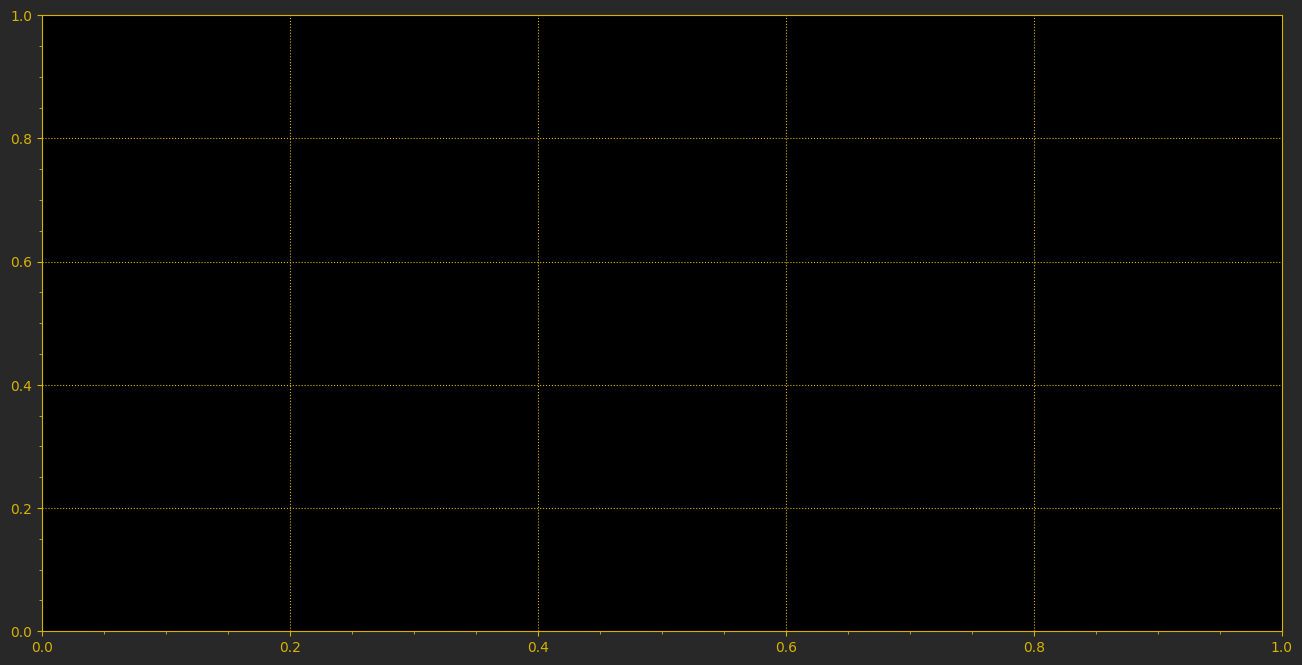

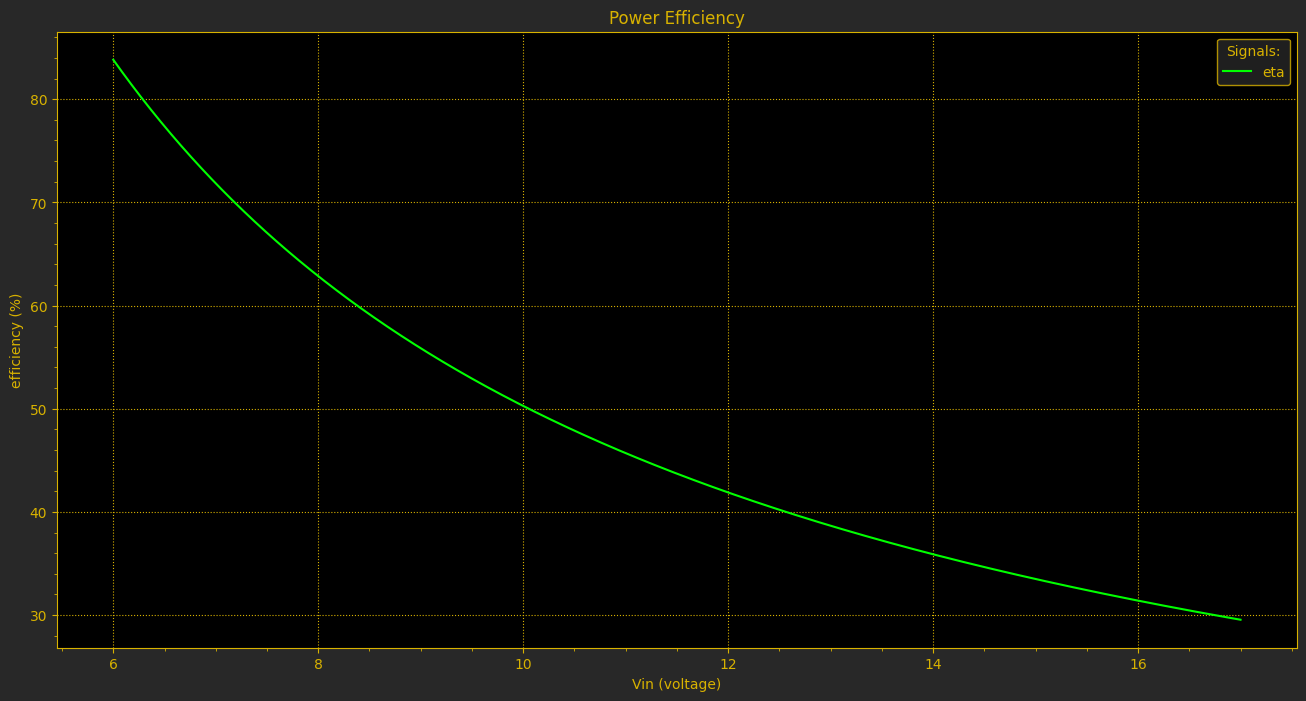

In [4]:
# Part 1


def part1(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list

    # 1st analysis: operating point
    op1 = spi.Analyses(
        name="op1",
        cmd_type="op",
        cmd="op",
        vector=my_vectors_dict[Ky.VEC_ALL],
        results_loc=my_paths_dict[Ky.RESULTS_PATH],
    )
    list_of_analyses.append(op1)

    # 2nd analysis: dc transfer
    dc1 = spi.Analyses(
        name="dc1",
        cmd_type="dc",
        cmd="dc vin 6 17 0.1",
        vector=my_vectors_dict[Ky.VEC_ALL],
        results_loc=my_paths_dict[Ky.RESULTS_PATH],
    )
    list_of_analyses.append(dc1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Ky.CONTROL] = spi.Netlist(str(my_control))

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Ky.TOP1] = (
        my_netlists_dict[Ky.TITLE]
        + my_netlists_dict[Ky.BLANKLINE]
        + my_netlists_dict[Ky.DUT]
        + my_netlists_dict[Ky.LOAD]
        + my_netlists_dict[Ky.BLANKLINE]
        + my_netlists_dict[Ky.SUPPLIES]
        + my_netlists_dict[Ky.BLANKLINE]
        + my_netlists_dict[Ky.STIMULUS]
        + my_netlists_dict[Ky.BLANKLINE]
        + my_netlists_dict[Ky.MODELS]
        + my_netlists_dict[Ky.BLANKLINE]
        + my_netlists_dict[Ky.CONTROL]
        + my_netlists_dict[Ky.END_LINE]
        + my_netlists_dict[Ky.BLANKLINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Ky.NETLISTS_PATH] / "top1.cir"
    my_netlists_dict[Ky.TOP1].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        ngspice_exe=my_paths_dict[Ky.NGSPICE_EXE],
        netlist_filename=top_filename,
        transcript_filename=my_paths_dict[Ky.SIM_TRANSCRIPT_FILENAME],
        name="sim1",
        timeout=20,
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]

    # give each SimResults object a more descriptive name
    op1_results, dc1_results = sim_results

    # diaplay results for operating point analysis
    spi.print_section("Operating Point Results", op1_results.table_for_print())

    # create waveform object for dc1 results and calculate power efficiency
    pwr1 = spi.Waveforms(dc1_results.header, dc1_results.data_plot)
    pwr1.vec_subset(vectors_dict[Ky.VEC_POWER_CALC].list_out())
    pwr1.multiply("in", "vin#branch", "pin")  # calc input power   
    pwr1.multiply("out", "vmeas#branch", "pout")  # calc output power
    pwr1.divide("pout", "pin", "eta_neg")  # calc efficiency
    pwr1.scaler(-100, "eta_neg", "eta")  # make positive value & convert to %

    # reduce waves to just "eta"
    pwr1.vec_subset(vectors_dict[Ky.VEC_ETA].list_out())

    # plot the efficiency vs. Vin
    plot_data = pwr1.x_axis_and_sigs(vectors_dict[Ky.VEC_ETA].list_out())
    y_names = vectors_dict[Ky.VEC_ETA].list_out()
    my_plt = spi.Plot("my_plot", plot_data, y_names, my_paths_dict[Ky.RESULTS_PATH])
    my_plt.set_title("Power Efficiency")
    my_plt.define_axes(("Vin", "voltage", "linear"), ("efficiency", "%", "linear"))

    return my_netlists_dict


netlists_dict = part1(paths_dict, netlists_dict, vectors_dict)

#### Main
Run all the parts at once so the results are together.

Note that with each "part" function the netlist_dict is updated (returned) with the top netlist from each part added to the dictionary.

In [5]:
# Execute all parts
# netlists_dict = part1(paths_dict, netlists_dict, vectors_dict)